## Regrillado para el Parque Nacional Terepaima

**PROYECTO:** SISTEMA PARA EL SEGUIMIENTO DE ECOSISTEMAS VENEZOLANOS \
**AUTOR:** Javier Martinez

In [1]:
import os

import rioxarray 
import xarray
from shapely.geometry import (Polygon, mapping)
import geopandas

import pandas as pd
from datetime import datetime
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

Directorio de trabajo

In [2]:
print('> Directorio actual: ', os.getcwd())  
os.chdir('../')
print('> Directorio actual: ', os.getcwd()) 

> Directorio actual:  /media/javier/Compartida/doctorado/gee-metview/terepaima/code
> Directorio actual:  /media/javier/Compartida/doctorado/gee-metview/terepaima


#### Polígonos del parque Cerro Saroche

In [3]:
park_poligono = geopandas.read_file('./polygons/park/terepaima.shp')
parque_rectangulo = geopandas.read_file('./polygons/rectangle/rectangulo_terepaima.shp')

#### Precipitación

* Transformación de la precipitación a NETCDF.

In [4]:
def precipitacion_netcdf(file):
        """
        Funcion para realizar la transformacion de la precipitacion a NETCDF
        """
        import warnings
        warnings.filterwarnings('ignore')

        precipitacion_rds = rioxarray.open_rasterio(file,
                                masked=True
                                )\
                                .squeeze()


        # Tranformando band a datetime 
        date_range = pd.date_range(start='1970-01-01',
                                freq='M',
                                periods = precipitacion_rds.band.values.shape[0]
                                )

        date_range = np.array(list(map(lambda x: datetime.strptime( str(x)[:8]+'01','%Y-%m-%d').toordinal(), date_range )))

        # creando netcdf
        ds_precipitacion = xarray.Dataset({
                'precipitacion_mm' : xarray.DataArray(
                        data = 1000*precipitacion_rds.data,
                        dims = ['time','y','x'],
                        coords = {'time':date_range,'y': precipitacion_rds['y'].data, 'x': precipitacion_rds['x'].data},
                        attrs = precipitacion_rds.attrs
                        )
                },
        attrs = {'GRIB_COMMENT': 'Total precipitation [mm]',
                'GRIB_ELEMENT': 'TP',
                'GRIB_FORECAST_SECONDS': 86400,
                'GRIB_REF_TIME': 0,
                'GRIB_SHORT_NAME': '0-SFC',
                'GRIB_UNIT': '[mm]',
                'GRIB_VALID_TIME': 86400,
                'scale_factor': 1.0,
                'add_offset': 0.0,
                'long_name': '0[-] SFC (Ground or water surface)'}
        )

        # agregando crs
        ds_precipitacion = ds_precipitacion.rio.set_crs(precipitacion_rds.rio.crs)
        ds_precipitacion = ds_precipitacion.rio.write_crs(precipitacion_rds.rio.crs)

        return ds_precipitacion

In [5]:
# directorio precipitacion
precipitacion_dir = './cdsapi/'

# archivos
precipitacion_files = list(filter(lambda x: x.find('grib')>0, os.listdir(precipitacion_dir)))
precipitacion_files

['total_precipitation_1970_2022.grib']

In [6]:
# aplicando transformacion
precipitacion_grib = list(map(lambda x: precipitacion_netcdf(precipitacion_dir + x), ['total_precipitation_1970_2022.grib']))

# integrando data
#ds_precipitacion =  xarray.concat( precipitacion_grib, dim="time").groupby('time').mean('time')
ds_precipitacion =  precipitacion_grib[0]

ERROR: Ran out of file reading SECT0


In [7]:
ds_precipitacion.rio.crs

CRS.from_wkt('GEOGCS["Coordinate System imported from GRIB file",DATUM["unnamed",SPHEROID["Sphere",6367470,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]')

In [8]:
# llegando a rectangulo
park_poligono = park_poligono.to_crs(ds_precipitacion.rio.crs)
parque_rectangulo = parque_rectangulo.to_crs(ds_precipitacion.rio.crs)

# rectangulo del parque
precipitacion_rectangulo = ds_precipitacion.rio.clip(parque_rectangulo.geometry.apply(mapping),
                                                    all_touched=False,
                                                    crs=ds_precipitacion.rio.crs,
                                                    from_disk=True)

In [9]:
ds_precipitacion

<xarray.Dataset>
Dimensions:           (time: 629, y: 7, x: 5)
Coordinates:
  * time              (time) int64 719163 719194 719222 ... 738215 738246 738276
  * y                 (y) float64 10.16 10.06 9.96 9.86 9.76 9.66 9.56
  * x                 (x) float64 -69.48 -69.38 -69.28 -69.18 -69.08
    spatial_ref       int64 0
Data variables:
    precipitacion_mm  (time, y, x) float64 1.272 1.31 1.296 ... 3.811 4.535
Attributes:
    GRIB_COMMENT:           Total precipitation [mm]
    GRIB_ELEMENT:           TP
    GRIB_FORECAST_SECONDS:  86400
    GRIB_REF_TIME:          0
    GRIB_SHORT_NAME:        0-SFC
    GRIB_UNIT:              [mm]
    GRIB_VALID_TIME:        86400
    scale_factor:           1.0
    add_offset:             0.0
    long_name:              0[-] SFC (Ground or water surface)

In [10]:
precipitacion_rectangulo

<xarray.Dataset>
Dimensions:           (y: 3, x: 3, time: 629)
Coordinates:
  * y                 (y) float64 9.96 9.86 9.76
  * x                 (x) float64 -69.38 -69.28 -69.18
  * time              (time) int64 719163 719194 719222 ... 738215 738246 738276
    spatial_ref       int64 0
Data variables:
    precipitacion_mm  (time, y, x) float64 1.698 1.375 1.234 ... 3.351 3.251
Attributes:
    GRIB_COMMENT:           Total precipitation [mm]
    GRIB_ELEMENT:           TP
    GRIB_FORECAST_SECONDS:  86400
    GRIB_REF_TIME:          0
    GRIB_SHORT_NAME:        0-SFC
    GRIB_UNIT:              [mm]
    GRIB_VALID_TIME:        86400
    scale_factor:           1.0
    add_offset:             0.0
    long_name:              0[-] SFC (Ground or water surface)

In [11]:
precipitacion_rectangulo.to_netcdf('./cdsapi/precipitacion_regrilla.nc')

In [12]:
date_srt = datetime.fromordinal(
                precipitacion_rectangulo.time.values[0])\
                  .strftime('%Y-%m-%d')

date_srt

'1970-01-01'

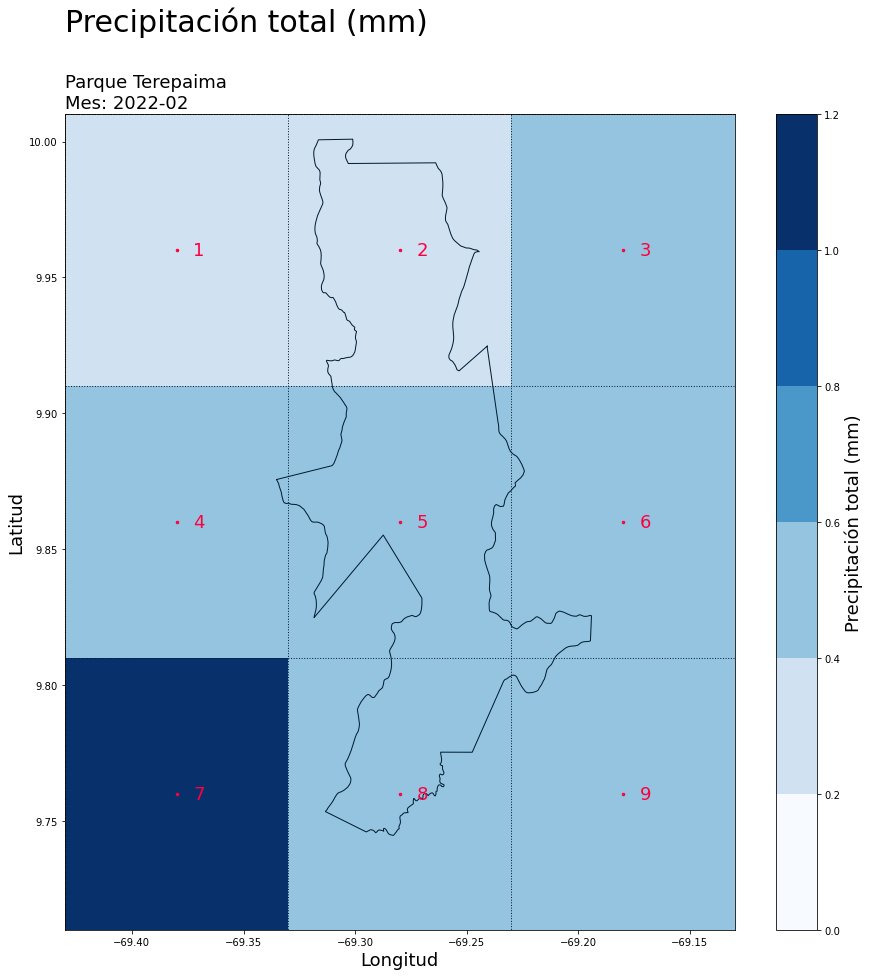

In [42]:
# centros
x = np.arange(-69.58,-68.98,0.1)
y = np.arange(9.56,10.16,0.1)

# grilla
x_grid = x + 0.05
y_grid  = y + 0.05


# plot
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(1, 1, 1)


# raster
time_lebel = 625
levels=[0,0.2,0.4,0.6,0.8,1,1.2]
graf = precipitacion_rectangulo.isel(time=time_lebel)\
                               .precipitacion_mm\
                               .plot(cmap='Blues',
                                    levels=levels
                                    )
graf.colorbar.set_label('Precipitación total (mm)',fontsize=18)
ax.add_collection(graf)

# poligonos
x1,y1 = park_poligono.geometry.iloc[0].exterior.xy
ax.plot(x1,y1, color='#001B32', linewidth=1)

x2,y2 = parque_rectangulo.geometry.iloc[0].exterior.xy
ax.plot(x2,y2, color='#BF6300', linewidth=1,linestyle='dashed')

# centroides
annotate = 1
annotate_list = 7*[0]+[7,4,1]+ 2*[0]+[8,5,2] + 2*[0]+[9,6,3] +20*[0]
for i in list(range(1, len(x) )):
  for j in list(range(1, len(y) )):
    ax.plot(x[i],y[j],color = '#FF003E', marker='.', label=i, markersize=5)
    if annotate_list[annotate]!=0:
      ax.annotate(str(annotate_list[annotate]),  xy=(x[i]+0.01,y[j]), color='#FF003E',
          fontsize=18, #weight='',
          horizontalalignment='center',
          verticalalignment='center')
    annotate+=1

# grilla
color_grid = '#001B32'
for i in list(range( len(x_grid) )):
  ax.vlines(x = x_grid[i],ymin=min(y_grid),ymax=max(y_grid),
            colors = color_grid,
            linestyles='dotted',
            linewidth=1,
            label = 'vline_multiple - full height')

for i in list(range( len(y_grid) )):
  ax.hlines(y = y_grid[i],xmin=min(x_grid),xmax=max(x_grid),
            colors = color_grid,
            linestyles='dotted',
            linewidth=1,
            label = 'vline_multiple - full height')


# dia
date_srt = datetime.fromordinal(
                precipitacion_rectangulo.time.values[time_lebel])\
                  .strftime('%Y-%m')

# titulos
plt.title(f"Parque Terepaima\nMes: {date_srt}",fontsize=18,loc='left')
plt.title(f"",fontsize=30,loc='center')
plt.suptitle(f"Precipitación total (mm)",ha='left',fontsize=30,x=0.125)
plt.xlabel("Longitud",loc='center',fontsize=18)
plt.ylabel("Latitud",loc='center',fontsize=18)

plt.xlim([-69.43, -69.13])
plt.ylim([9.71, 10.01])

plt.savefig('./figures/grilla_precipitacion_terepaima.png')

plt.show()

#### Elevación

In [14]:
elevacion_rds = rioxarray.open_rasterio('./SRTMGL3/elevacion.nc',
                              masked=True
                              )\
                              .squeeze()\
                              .to_dataset()

elevacion = elevacion_rds.rio.reproject(ds_precipitacion.rio.crs)

In [15]:
# elevacion del parque
elevacion_park = elevacion.rio.clip(parque_rectangulo.geometry.apply(mapping),
                    all_touched=False,
                    from_disk=True)\
                    .squeeze()\
                    .chunk("auto")

elevacion_park

<xarray.Dataset>
Dimensions:      (y: 360, x: 361)
Coordinates:
  * y            (y) float64 10.01 10.01 10.01 10.01 ... 9.713 9.713 9.712 9.711
  * x            (x) float64 -69.43 -69.43 -69.43 ... -69.13 -69.13 -69.13
    band         int64 1
    spatial_ref  int64 0
Data variables:
    elevacion    (y, x) float32 dask.array<chunksize=(360, 361), meta=np.ndarray>

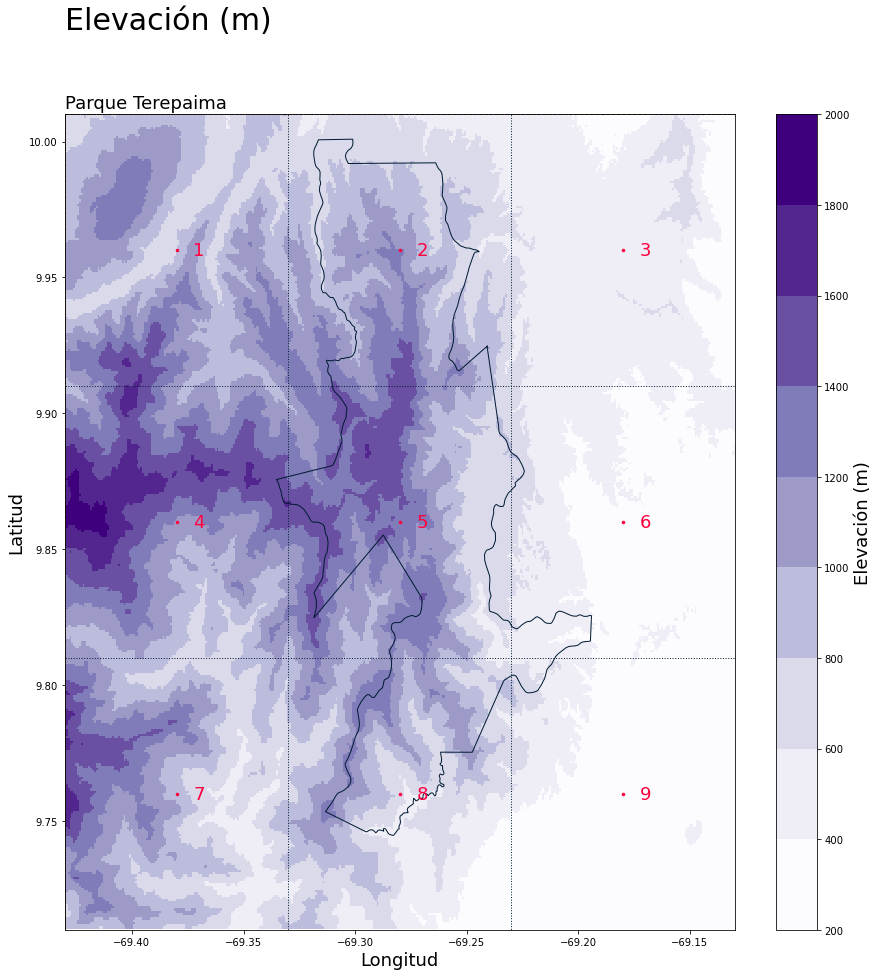

In [49]:
# centros
x = np.arange(-69.58,-68.98,0.1)
y = np.arange(9.56,10.16,0.1)

# grilla
x_grid = x + 0.05
y_grid  = y + 0.05

# plot
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(1, 1, 1)

# raster
levels=[200, 400, 600, 800, 1000, 1200, 1400,1600, 1800, 2000]
graf = elevacion_park.elevacion.plot(cmap='Purples',levels=levels)
graf.colorbar.set_label('Elevación (m)',fontsize=18)
ax.add_collection(graf)

# poligonos
x1,y1 = park_poligono.geometry.iloc[0].exterior.xy
ax.plot(x1,y1, color='#001B32', linewidth=1)

x2,y2 = parque_rectangulo.geometry.iloc[0].exterior.xy
ax.plot(x2,y2, color='#BF6300', linewidth=1,linestyle='dashed')


# centroides
annotate = 1
annotate_list = 7*[0]+[7,4,1]+ 2*[0]+[8,5,2] + 2*[0]+[9,6,3] +20*[0]
for i in list(range(1, len(x) )):
  for j in list(range(1, len(y) )):
    ax.plot(x[i],y[j],color = '#FF003E', marker='.', label=i, markersize=5)
    if annotate_list[annotate]!=0:
      ax.annotate(str(annotate_list[annotate]),  xy=(x[i]+0.01,y[j]), color='#FF003E',
          fontsize=18, #weight='',
          horizontalalignment='center',
          verticalalignment='center')
    annotate+=1

# grilla
color_grid = '#001B32'
for i in list(range( len(x_grid) )):
  ax.vlines(x = x_grid[i],ymin=min(y_grid),ymax=max(y_grid),
            colors = color_grid,
            linestyles='dotted',
            linewidth=1,
            label = 'vline_multiple - full height')

for i in list(range( len(y_grid) )):
  ax.hlines(y = y_grid[i],xmin=min(x_grid),xmax=max(x_grid),
            colors = color_grid,
            linestyles='dotted',
            linewidth=1,
            label = 'vline_multiple - full height')

# titulos
plt.title(f"Parque Terepaima",fontsize=18,loc='left')
plt.title(f"",fontsize=30,loc='center')
plt.suptitle(f"Elevación (m)",ha='left',fontsize=30,x=0.125)
plt.xlabel("Longitud",loc='center',fontsize=18)
plt.ylabel("Latitud",loc='center',fontsize=18)

plt.xlim([-69.43, -69.13])
plt.ylim([9.71, 10.01])

plt.savefig('./figures/grilla_elevacion_terepaima.png')

plt.show()

#### Regrillado elevación

In [17]:
import warnings
warnings.filterwarnings("ignore")


rds = ds_precipitacion
rds_trgrilla = elevacion
band = 'elevacion'
x_name='x'
y_name='y'


y = rds[y_name].to_numpy()
x = rds[x_name].to_numpy()

# grilla
y_grid = y + 0.05
x_grid = x + 0.05

list_grid = []
for i, i_ in enumerate(y_grid[:-1]):
  list_i = []
  for j, j_ in enumerate(x_grid[:-1]):
    poly = Polygon( [(x_grid[j],y_grid[i,]),(x_grid[j+1],y_grid[i]),(x_grid[j+1],y_grid[i+1]),(x_grid[j],y_grid[i+1]),(x_grid[j],y_grid[i,])] )
    poligono = geopandas.GeoSeries(poly, crs = rds.rio.crs) 
    region = rds_trgrilla.rio.clip(poligono.geometry.apply(mapping),
                          all_touched=False,
                          from_disk=True)
    list_i.append({ 'x':j_,
                    'y':i_,
                    'mean': float(region[band].mean()),
                    'median': float(region[band].median()),
                    'max': float(region[band].max()),
                    'centroide': (float(poligono.centroid.x), float(poligono.centroid.y)),
                    'poligono':poligono,
                    'region':region
                    }) 
  
  list_grid.append(list_i)

In [18]:
centroide_x = list(map(lambda x: [y.get('centroide')[0] for y in x] , list_grid))[0]
centroide_y = list(map(lambda x: [y.get('centroide')[1] for y in x][0] , list_grid))

media = list(map(lambda x: [y.get('mean') for y in x] , list_grid))
mediana = list(map(lambda x: [y.get('median') for y in x] , list_grid))
maximo = list(map(lambda x: [y.get('max') for y in x] , list_grid))

In [19]:
fieldset = [{
              "gridType": "regular_ll",
              "Nx": len(centroide_x),
              "Ny": len(centroide_y),
              "distinctLatitudes": centroide_y,
              "distinctLongitudes": centroide_x,
              "paramId": 1,
              "shortName": f"{band}_media",
              "values": media,
              "dataDate": 20211216,
              "dataTime": 1200
              },
              {
              "gridType": "regular_ll",
              "Nx": len(centroide_x),
              "Ny": len(centroide_y),
              "distinctLatitudes": centroide_y,
              "distinctLongitudes": centroide_x,
              "paramId": 2,
              "shortName": f"{band}_mediana",
              "values": mediana,
              "dataDate": 20211216,
              "dataTime": 1200
              },
              {
              "gridType": "regular_ll",
              "Nx": len(centroide_x),
              "Ny": len(centroide_y),
              "distinctLatitudes": centroide_y,
              "distinctLongitudes": centroide_x,
              "paramId": 3,
              "shortName": f"{band}_maxima",
              "values": maximo,
              "dataDate": 20211216,
              "dataTime": 1200
              }
              ]

ds = xarray.open_dataset(fieldset, engine="cfgrib")
ds = ds.rio.write_crs(ds_precipitacion.rio.crs)

#ds.to_netcdf('./cerro_saroche/SRTMGL3/elevacion_regrilla.nc')

In [20]:
# elevacion del parque
ds_rect = ds.rio.clip(parque_rectangulo.geometry.apply(mapping),
                    all_touched=False,
                    from_disk=True)

ds_rect.to_netcdf('./SRTMGL3/elevacion_regrilla.nc')

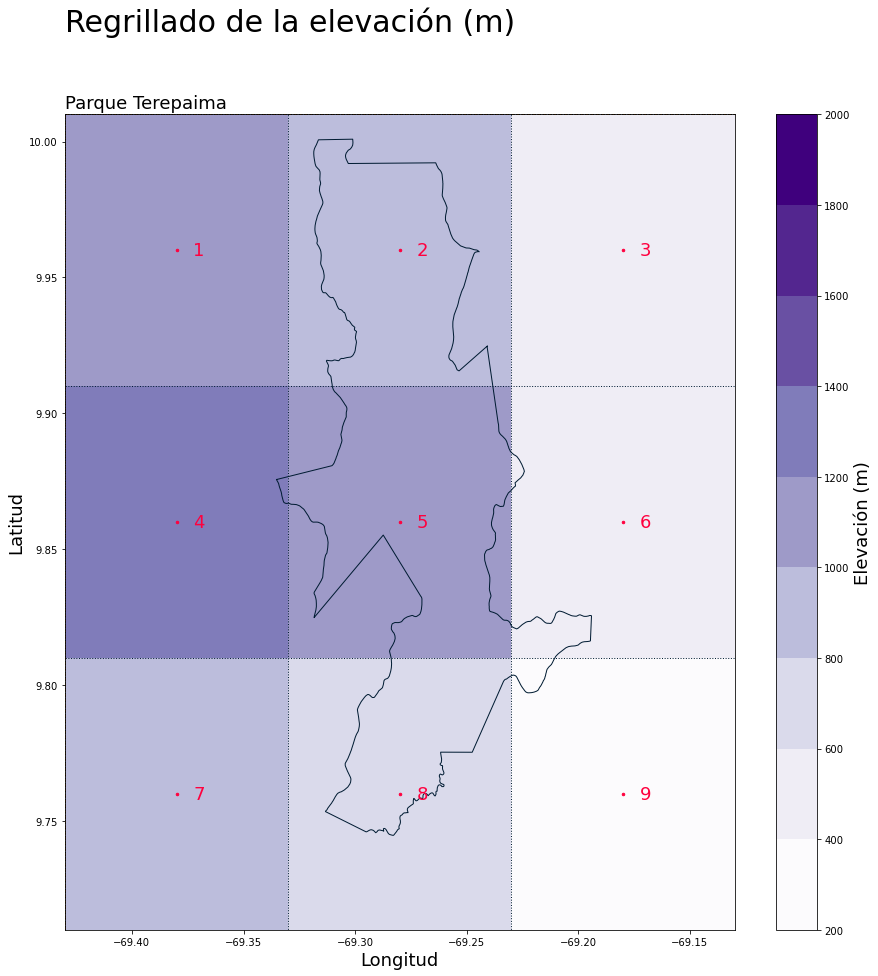

In [50]:
# centros
x = np.arange(-69.58,-68.98,0.1)
y = np.arange(9.56,10.16,0.1)

# grilla
x_grid = x + 0.05
y_grid  = y + 0.05

# plot
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(1, 1, 1)

# raster
# raster
levels=[200, 400, 600, 800, 1000, 1200, 1400,1600, 1800, 2000]
graf = ds_rect.elevacion_media.plot(cmap='Purples',levels=levels)
graf.colorbar.set_label('Elevación (m)',fontsize=18)
ax.add_collection(graf)

# poligonos
x1,y1 = park_poligono.geometry.iloc[0].exterior.xy
ax.plot(x1,y1, color='#001B32', linewidth=1)

x2,y2 = parque_rectangulo.geometry.iloc[0].exterior.xy
ax.plot(x2,y2, color='#BF6300', linewidth=1,linestyle='dashed')

# centroides
annotate = 1
annotate_list = 7*[0]+[7,4,1]+ 2*[0]+[8,5,2] + 2*[0]+[9,6,3] +20*[0]
for i in list(range(1, len(x) )):
  for j in list(range(1, len(y) )):
    ax.plot(x[i],y[j],color = '#FF003E', marker='.', label=i, markersize=5)
    if annotate_list[annotate]!=0:
      ax.annotate(str(annotate_list[annotate]),  xy=(x[i]+0.01,y[j]), color='#FF003E',
          fontsize=18, #weight='',
          horizontalalignment='center',
          verticalalignment='center')
    annotate+=1

# grilla
color_grid = '#001B32'
for i in list(range( len(x_grid) )):
  ax.vlines(x = x_grid[i],ymin=min(y_grid),ymax=max(y_grid),
            colors = color_grid,
            linestyles='dotted',
            linewidth=1,
            label = 'vline_multiple - full height')

for i in list(range( len(y_grid) )):
  ax.hlines(y = y_grid[i],xmin=min(x_grid),xmax=max(x_grid),
            colors = color_grid,
            linestyles='dotted',
            linewidth=1,
            label = 'vline_multiple - full height')


# titulos
plt.title(f"Parque Terepaima",fontsize=18,loc='left')
plt.title(f"",fontsize=30,loc='center')
plt.suptitle(f"Regrillado de la elevación (m)",ha='left',fontsize=30,x=0.125)
plt.xlabel("Longitud",loc='center',fontsize=18)
plt.ylabel("Latitud",loc='center',fontsize=18)

plt.xlim([-69.43, -69.13])
plt.ylim([9.71, 10.01])

plt.savefig('./figures/regrillado_elevacion_terepaima.png')

plt.show()

#### Vegetación

In [22]:
# BUscando el archivo mas actualizado
vegetacion_dir = './MOD13Q1_V6/summary/'

files_vegetacion = os.listdir(vegetacion_dir)
vegetacion_max_file = max(list(map(lambda x: datetime.strptime(x.split('.')[3],'%Y%m%d'), files_vegetacion)))

vegetacion_file = list(filter(lambda x: datetime.strptime(x.split('.')[3],'%Y%m%d') == vegetacion_max_file, files_vegetacion))[0]

In [23]:
vegetacion_max_file.strftime('%Y%m%d')

'20220626'

In [24]:
path_vegetacion = vegetacion_dir + vegetacion_file
rds = rioxarray.open_rasterio(path_vegetacion,
                              masked=True
                              ).squeeze()

# cambiando proyeccion
rds_vegetacion = rds.rio.reproject(ds_precipitacion.rio.crs)

In [25]:
rds_vegetacion

<xarray.Dataset>
Dimensions:                  (x: 83, y: 112, time: 202)
Coordinates:
  * x                        (x) float64 -69.37 -69.36 -69.36 ... -69.18 -69.18
  * y                        (y) float64 10.0 9.999 9.996 ... 9.75 9.748 9.746
  * time                     (time) int64 734503 734519 734535 ... 738316 738332
    spatial_ref              int64 0
Data variables:
    250m 16 days NDVI        (time, y, x) float32 nan nan nan ... nan nan nan
    250m 16 days EVI         (time, y, x) float32 nan nan nan ... nan nan nan
    250m 16 days VI Quality  (time, y, x) float32 nan nan nan ... nan nan nan
    QA_EVI                   (time, y, x) float32 nan nan nan ... nan nan nan
    QA_NDVI                  (time, y, x) float32 nan nan nan ... nan nan nan
Attributes: (12/173)
    ALGORITHMPACKAGEACCEPTANCEDATE:      102004
    ALGORITHMPACKAGEMATURITYCODE:        Normal
    ALGORITHMPACKAGENAME:                MOD_PR13A1
    ALGORITHMPACKAGEVERSION:             6
    ASSOCIATEDINSTRUMENTSHORTNAME.1:     MODIS
    ASSOCIATEDPLATFORMSHORTNAME.1:       Terra
    ...                                  ...
    SOUTHBOUNDINGCOORDINATE:             0
    SPSOPARAMETERS:                      2749, 4334, 2749a, 4334a
    TileID:                              51010008
    VERSIONID:                           6
    VERTICALTILENUMBER:                  8
    WESTBOUNDINGCOORDINATE:              -81.23412894334

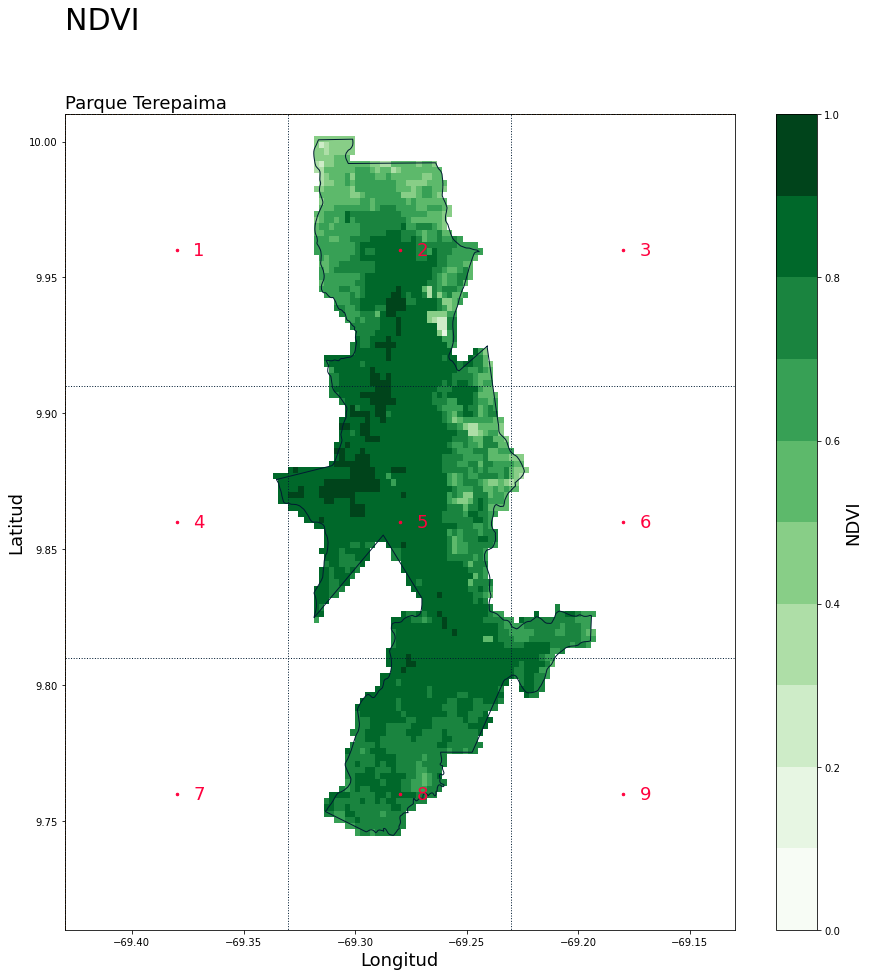

In [26]:
# centros
x = np.arange(-69.58,-68.98,0.1)
y = np.arange(9.56,10.16,0.1)

# grilla
x_grid = x + 0.05
y_grid  = y + 0.05

# plot
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(1, 1, 1)

# raster
time_lebel = 193
levels=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
graf = rds_vegetacion.isel(time=time_lebel).QA_NDVI.plot(cmap='Greens',levels=levels)
graf.colorbar.set_label('NDVI',fontsize=18)
ax.add_collection(graf)

# poligonos
x1,y1 = park_poligono.geometry.iloc[0].exterior.xy
ax.plot(x1,y1, color='#001B32', linewidth=1)

x2,y2 = parque_rectangulo.geometry.iloc[0].exterior.xy
ax.plot(x2,y2, color='#BF6300', linewidth=1,linestyle='dashed')


# centroides
annotate = 1
annotate_list = 7*[0]+[7,4,1]+ 2*[0]+[8,5,2] + 2*[0]+[9,6,3] +20*[0]
for i in list(range(1, len(x) )):
  for j in list(range(1, len(y) )):
    ax.plot(x[i],y[j],color = '#FF003E', marker='.', label=i, markersize=5)
    if annotate_list[annotate]!=0:
      ax.annotate(str(annotate_list[annotate]),  xy=(x[i]+0.01,y[j]), color='#FF003E',
          fontsize=18, #weight='',
          horizontalalignment='center',
          verticalalignment='center')
    annotate+=1

# grilla
color_grid = '#001B32'
for i in list(range( len(x_grid) )):
  ax.vlines(x = x_grid[i],ymin=min(y_grid),ymax=max(y_grid),
            colors = color_grid,
            linestyles='dotted',
            linewidth=1,
            label = 'vline_multiple - full height')

for i in list(range( len(y_grid) )):
  ax.hlines(y = y_grid[i],xmin=min(x_grid),xmax=max(x_grid),
            colors = color_grid,
            linestyles='dotted',
            linewidth=1,
            label = 'vline_multiple - full height')

# dia
date_srt = datetime.fromordinal(
                rds_vegetacion.time.values[time_lebel])\
                  .strftime('%Y-%m-%d')

# titulos
plt.title(f"Parque Terepaima",fontsize=18,loc='left')
plt.title(f"",fontsize=30,loc='center')
plt.suptitle(f"NDVI",ha='left',fontsize=30,x=0.125)
plt.xlabel("Longitud",loc='center',fontsize=18)
plt.ylabel("Latitud",loc='center',fontsize=18)

plt.xlim([-69.43, -69.13])
plt.ylim([9.71, 10.01])

plt.show()

#### Llevando ndvi a valores mensuales

In [27]:
time = list(map(lambda x: datetime.fromordinal(x).strftime('%Y-%m'),
                            rds_vegetacion.time.values.tolist()
                ))

time = list(map(lambda x: datetime.strptime(x+'-01','%Y-%m-%d').toordinal() ,time))

# creando netcdf
ds_ndvi = xarray.Dataset({
        'ndvi' : xarray.DataArray(
                    data = rds_vegetacion.QA_NDVI.data,
                    dims = ['time','y','x'],
                    coords = {'time':time,'y': rds_vegetacion['y'].data, 'x': rds_vegetacion['x'].data},
                    attrs = rds_vegetacion.attrs
                    )
          },
    attrs = rds_vegetacion.attrs
    )

# agregando ds_ndvi
ds_ndvi = ds_ndvi.rio.set_crs(ds_precipitacion.rio.crs)
ds_ndvi = ds_ndvi.rio.write_crs(ds_precipitacion.rio.crs)

In [28]:
# Agrupando los valores a mensuales
ds_ndvi_mes = ds_ndvi.groupby('time').mean('time')
ds_ndvi_mes

<xarray.Dataset>
Dimensions:      (y: 112, x: 83, time: 112)
Coordinates:
  * y            (y) float64 10.0 9.999 9.996 9.994 ... 9.753 9.75 9.748 9.746
  * x            (x) float64 -69.37 -69.36 -69.36 ... -69.18 -69.18 -69.18
    spatial_ref  int64 0
  * time         (time) int64 734503 734534 734563 ... 738246 738276 738307
Data variables:
    ndvi         (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan

In [29]:
datetime.fromordinal(ds_ndvi_mes.time.values[0]).strftime('%Y-%m')

'2012-01'

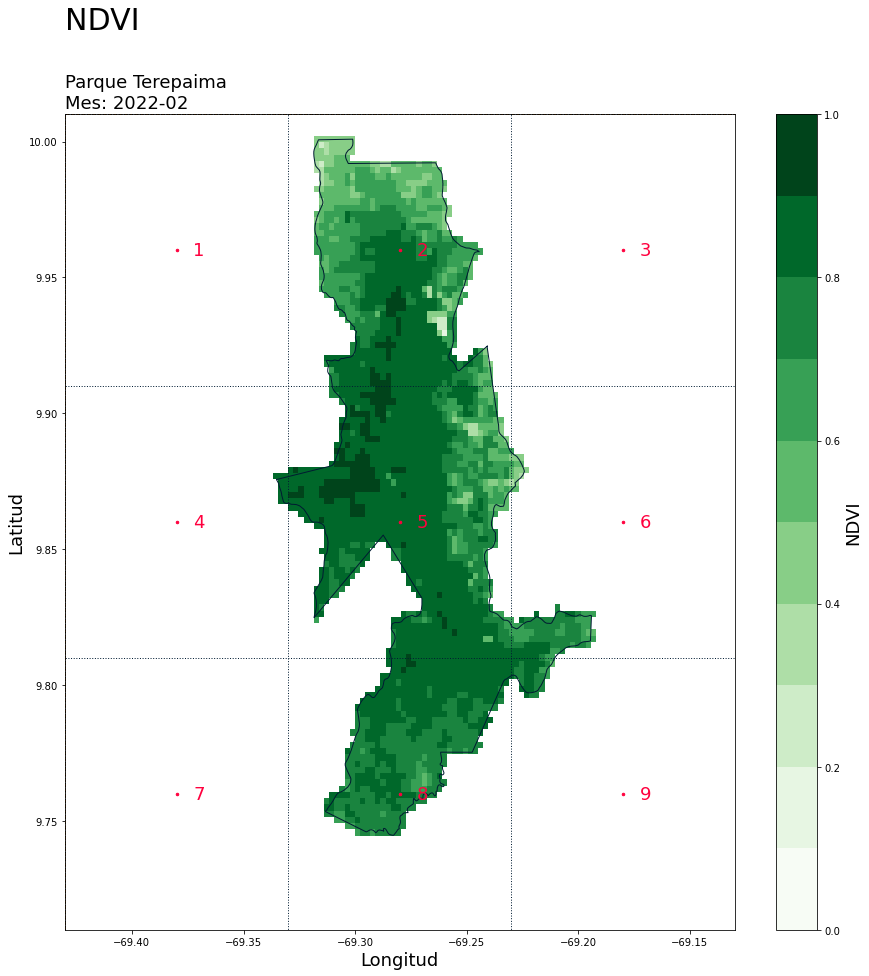

In [30]:
# centros
x = np.arange(-69.58,-68.98,0.1)
y = np.arange(9.56,10.16,0.1)

# grilla
x_grid = x + 0.05
y_grid  = y + 0.05

# plot
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(1, 1, 1)

# raster
time_lebel = 107
levels=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
graf = ds_ndvi_mes.isel(time=time_lebel).ndvi.plot(cmap='Greens',levels=levels)
graf.colorbar.set_label('NDVI',fontsize=18)
ax.add_collection(graf)

# poligonos
x1,y1 = park_poligono.geometry.iloc[0].exterior.xy
ax.plot(x1,y1, color='#001B32', linewidth=1)

x2,y2 = parque_rectangulo.geometry.iloc[0].exterior.xy
ax.plot(x2,y2, color='#BF6300', linewidth=1,linestyle='dashed')


# centroides
annotate = 1
annotate_list = 7*[0]+[7,4,1]+ 2*[0]+[8,5,2] + 2*[0]+[9,6,3] +20*[0]
for i in list(range(1, len(x) )):
  for j in list(range(1, len(y) )):
    ax.plot(x[i],y[j],color = '#FF003E', marker='.', label=i, markersize=5)
    if annotate_list[annotate]!=0:
      ax.annotate(str(annotate_list[annotate]),  xy=(x[i]+0.01,y[j]), color='#FF003E',
          fontsize=18, #weight='',
          horizontalalignment='center',
          verticalalignment='center')
    annotate+=1

# grilla
color_grid = '#001B32'
for i in list(range( len(x_grid) )):
  ax.vlines(x = x_grid[i],ymin=min(y_grid),ymax=max(y_grid),
            colors = color_grid,
            linestyles='dotted',
            linewidth=1,
            label = 'vline_multiple - full height')

for i in list(range( len(y_grid) )):
  ax.hlines(y = y_grid[i],xmin=min(x_grid),xmax=max(x_grid),
            colors = color_grid,
            linestyles='dotted',
            linewidth=1,
            label = 'vline_multiple - full height')

# dia
date_srt = datetime.fromordinal(ds_ndvi_mes.time.values[time_lebel]).strftime('%Y-%m')

# titulos
plt.title(f"Parque Terepaima\nMes: {date_srt}",fontsize=18,loc='left')
plt.title(f"",fontsize=30,loc='center')
plt.suptitle(f"NDVI",ha='left',fontsize=30,x=0.125)
plt.xlabel("Longitud",loc='center',fontsize=18)
plt.ylabel("Latitud",loc='center',fontsize=18)
plt.xlim([-69.43, -69.13])
plt.ylim([9.71, 10.01])

plt.savefig('./figures/grilla_ndvi_mes_terepaima.png')

plt.show()

#### Regrillado vegetación

In [31]:
ds_ndvi_mes

<xarray.Dataset>
Dimensions:      (y: 112, x: 83, time: 112)
Coordinates:
  * y            (y) float64 10.0 9.999 9.996 9.994 ... 9.753 9.75 9.748 9.746
  * x            (x) float64 -69.37 -69.36 -69.36 ... -69.18 -69.18 -69.18
    spatial_ref  int64 0
  * time         (time) int64 734503 734534 734563 ... 738246 738276 738307
Data variables:
    ndvi         (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan

In [32]:
import warnings
warnings.filterwarnings("ignore")

def regrillado_ndvi( time_lebel = 0,
                    rds = ds_precipitacion,
                    rds_trgrilla = ds_ndvi_mes,
                    band = 'ndvi',
                    x_name='x',
                    y_name='y'):


  rds_trgrilla = rds_trgrilla.isel(time=time_lebel)

  y = rds[y_name].to_numpy()
  x = rds[x_name].to_numpy()

  # grilla
  y_grid = y + 0.05
  x_grid = x + 0.05

  list_grid = []
  for i, i_ in enumerate(y_grid[:-1]):
    list_i = []
    for j, j_ in enumerate(x_grid[:-1]):
      try:
        poly = Polygon( [(x_grid[j],y_grid[i,]),(x_grid[j+1],y_grid[i]),(x_grid[j+1],y_grid[i+1]),(x_grid[j],y_grid[i+1]),(x_grid[j],y_grid[i,])] )
        poligono = geopandas.GeoSeries(poly, crs = rds.rio.crs) 
        region = rds_trgrilla.rio.clip(poligono.geometry.apply(mapping),
                              all_touched=False,
                              from_disk=True)
        list_i.append({ 'x':j_,
                        'y':i_,
                        'mean': float(region[band].mean()),
                        'median': float(region[band].median()),
                        'max': float(region[band].max()),
                        'centroide': (float(poligono.centroid.x), float(poligono.centroid.y)),
                        'poligono':poligono,
                        'region':region
                        }) 
      except:
        pass
    
    list_grid.append(list_i)

  #-----------------------
  # eliminando nulos
  list_grid = list(filter(lambda x: x != [],list_grid))

  centroide_x = list(map(lambda x: [y.get('centroide')[0] for y in x] , list_grid))[0]
  centroide_y = list(map(lambda x: [y.get('centroide')[1] for y in x][0] , list_grid))

  media = list(map(lambda x: [y.get('mean') for y in x] , list_grid))
  mediana = list(map(lambda x: [y.get('median') for y in x] , list_grid))
  maximo = list(map(lambda x: [y.get('max') for y in x] , list_grid))


  #-----------------------
  # ceando xarray
  fieldset = [{
                "gridType": "regular_ll",
                "Nx": len(centroide_x),
                "Ny": len(centroide_y),
                "distinctLatitudes": centroide_y,
                "distinctLongitudes": centroide_x,
                "paramId": 1,
                "shortName": f"{band}_media",
                "values": media,
                "time": rds_trgrilla.time.values
                #"dataTime": 1200
                },
                {
                "gridType": "regular_ll",
                "Nx": len(centroide_x),
                "Ny": len(centroide_y),
                "distinctLatitudes": centroide_y,
                "distinctLongitudes": centroide_x,
                "paramId": 2,
                "shortName": f"{band}_mediana",
                "values": mediana,
                "time": rds_trgrilla.time.values
                #"dataTime": 1200
                },
                {
                "gridType": "regular_ll",
                "Nx": len(centroide_x),
                "Ny": len(centroide_y),
                "distinctLatitudes": centroide_y,
                "distinctLongitudes": centroide_x,
                "paramId": 3,
                "shortName": f"{band}_maxima",
                "values": maximo,
                "time": rds_trgrilla.time.values
                #"dataTime": 1200
                }
                ]

  ds = xarray.open_dataset(fieldset, engine="cfgrib")
  ds  = ds.assign_coords(time =rds_trgrilla.time.values)
  ds  = ds.expand_dims(dim="time")

  ds = ds.rio.write_crs(ds_precipitacion.rio.crs)

  return ds

In [33]:
list_ndvi = list(map(lambda x: regrillado_ndvi( time_lebel = x,
                                                rds = ds_precipitacion,
                                                rds_trgrilla = ds_ndvi_mes,
                                                band = 'ndvi',
                                                x_name='x',
                                                y_name='y'),
                    list( range(0,len(ds_ndvi_mes.time.values.tolist()) ))

                    ))

In [34]:
rds_ndvi = xarray.concat( list_ndvi, dim="time" )

rds_ndvi.to_netcdf('./ndvi/ndvi_regrilla.nc')

In [35]:
rds_ndvi.rio.crs

CRS.from_wkt('GEOGCS["Coordinate System imported from GRIB file",DATUM["unnamed",SPHEROID["Sphere",6367470,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]')

In [36]:
rds_ndvi

<xarray.Dataset>
Dimensions:       (latitude: 3, longitude: 3, time: 112)
Coordinates:
  * latitude      (latitude) float64 9.96 9.86 9.76
  * longitude     (longitude) float64 -69.38 -69.28 -69.18
  * time          (time) int64 734503 734534 734563 ... 738246 738276 738307
    spatial_ref   int64 0
Data variables:
    ndvi_media    (time, latitude, longitude) float32 nan 0.8036 ... 0.8218
    ndvi_mediana  (time, latitude, longitude) float32 nan 0.8255 ... 0.8383
    ndvi_maxima   (time, latitude, longitude) float32 nan 0.9269 ... 0.8934
Attributes:
    Conventions:  CF-1.7
    history:      2022-08-20T13:00 GRIB to CDM+CF via cfgrib-0.9.10.1/ecCodes...

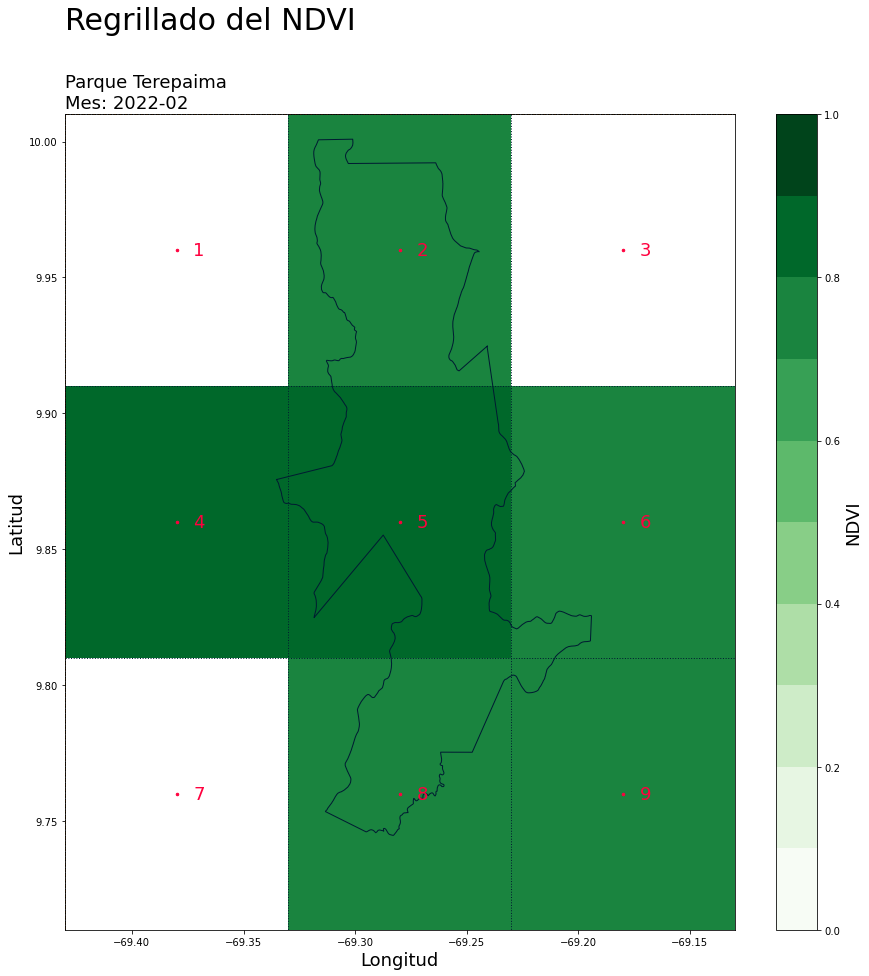

In [37]:
# centros
x = np.arange(-69.58,-68.98,0.1)
y = np.arange(9.56,10.16,0.1)

# grilla
x_grid = x + 0.05
y_grid  = y + 0.05

# plot
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(1, 1, 1)

# raster
time_lebel = 107
levels=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
graf = rds_ndvi.isel(time=time_lebel).ndvi_media.plot(cmap='Greens',
                                                      levels=levels
                                                      )
graf.colorbar.set_label('NDVI',fontsize=18)
ax.add_collection(graf)

# poligonos
x1,y1 = park_poligono.geometry.iloc[0].exterior.xy
ax.plot(x1,y1, color='#001B32', linewidth=1)

x2,y2 = parque_rectangulo.geometry.iloc[0].exterior.xy
ax.plot(x2,y2, color='#BF6300', linewidth=1,linestyle='dashed')


# centroides
annotate = 1
annotate_list = 7*[0]+[7,4,1]+ 2*[0]+[8,5,2] + 2*[0]+[9,6,3] +20*[0]
for i in list(range(1, len(x) )):
  for j in list(range(1, len(y) )):
    ax.plot(x[i],y[j],color = '#FF003E', marker='.', label=i, markersize=5)
    if annotate_list[annotate]!=0:
      ax.annotate(str(annotate_list[annotate]),  xy=(x[i]+0.01,y[j]), color='#FF003E',
          fontsize=18, #weight='',
          horizontalalignment='center',
          verticalalignment='center')
    annotate+=1

# grilla
color_grid = '#001B32'
for i in list(range( len(x_grid) )):
  ax.vlines(x = x_grid[i],ymin=min(y_grid),ymax=max(y_grid),
            colors = color_grid,
            linestyles='dotted',
            linewidth=1,
            label = 'vline_multiple - full height')

for i in list(range( len(y_grid) )):
  ax.hlines(y = y_grid[i],xmin=min(x_grid),xmax=max(x_grid),
            colors = color_grid,
            linestyles='dotted',
            linewidth=1,
            label = 'vline_multiple - full height')

# dia
date_srt = datetime.fromordinal(rds_ndvi.time.values[time_lebel]).strftime('%Y-%m')

# titulos
plt.title(f"Parque Terepaima\nMes: {date_srt}",fontsize=18,loc='left')
plt.title(f"",fontsize=30,loc='center')
plt.suptitle(f"Regrillado del NDVI",ha='left',fontsize=30,x=0.125)
plt.xlabel("Longitud",loc='center',fontsize=18)
plt.ylabel("Latitud",loc='center',fontsize=18)
plt.xlim([-69.43, -69.13])
plt.ylim([9.71, 10.01])

plt.savefig('./figures/regrillado_ndvi_mes_terepaima.png')

plt.show()